In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels
import statsmodels.sandbox.stats.multicomp

%matplotlib inline

Сгенерируем данные с одинаковыми средними

In [2]:
data_fst = np.random.normal(10, 10, size=100)
data_snd = np.random.normal(10, 1, size=100)

Если мы посмотрим на средние значения выборок, то они конечно же будут различны

In [3]:
print(data_fst.mean())
print(data_snd.mean())

9.15927137597379
10.067328849532688


Но если средние разные, то числа тоже могут не сильно отличаться

In [4]:
data_fst = np.random.normal(10.5, 10, size=100)
data_snd = np.random.normal(10, 1, size=100)

print(data_fst.mean())
print(data_snd.mean())

11.196219361782743
9.91201356911673


# Использование ЦПТ

### Можно воспользоваться ЦПТ и получить доверительный интервал для среднего

#### Напоминание ЦПТ:
Пусть $\xi_1, \xi_2, \dots$ - независимые одинаково распределённые случайные величины с конечной дисперсией $D \xi_1$ и мат. ожиданием $E \xi_1$, тогда

$\sqrt{\frac{n}{D \xi_1}} \left(\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - E \xi_1\right) \to_{n \to \infty} \mathcal{N}(0, 1)$ 

Отсюда можно сделать вывод, что при больших $n$ величина $\frac{\sum\limits_{i=1}^{n} \xi_i}{n}$ будет распределена примерно как $\mathcal{N}(E \xi_1, \frac{D \xi_1}{n})$

Если бы мы знали $D \xi_1$, то отсюда можно получить интервал на $E \xi_1$:
$$
P\left(E \xi_1 \in \left[\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - 1.96 \sqrt{\frac{D \xi_1}{n}}, \frac{\sum\limits_{i=1}^{n} \xi_i}{n} + 1.96 \sqrt{\frac{D \xi_1}{n}}\right]\right) \approx 0.95
$$

$D \xi_1$ можно оценить по выборке

In [5]:
def get_95_interval(data, sigma=None):
    mean = data.mean()
    if sigma is None:
        sigma = data.std()
    err = sigma * 1.96 / np.sqrt(len(data))
    return mean - err, mean + err

Проверим, что нужное нам значение лежит в интервале с требуемой вероятностью

In [6]:
hits = 0.
count = 0.
true_mean = 10.

for _ in range(10000):
    data = np.random.normal(true_mean, 10, size=100)
    lower_bound, upper_bound = get_95_interval(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.947


Однако, если данных мало, то оценка неправильна

In [7]:
hits = 0.
count = 0.
true_mean = 10.

for _ in range(10000):
    data = np.random.normal(true_mean, 10, size=10)
    lower_bound, upper_bound = get_95_interval(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.9045


Подставим реальное значение дисперсии и всё снова заработает

In [8]:
hits = 0.
count = 0.
true_mean = 10.

for _ in range(10000):
    data = np.random.normal(true_mean, 10, size=10)
    lower_bound, upper_bound = get_95_interval(data, sigma=10)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.9482


Итак, у нас две выборки с гигантской разницей в среднем

In [9]:
data_fst = np.random.normal(10.5, 10, size=100)
data_snd = np.random.normal(100, 1, size=100)

print(get_95_interval(data_fst))
print(get_95_interval(data_snd))

(8.628718849105246, 12.303424915192926)
(99.81602582974769, 100.21434433075306)


Конечно же интервалы не пересекаются

Однако, если разница небольшая, то интервалы могут пересечься

In [10]:
data_fst = np.random.normal(11, 10, size=500)
data_snd = np.random.normal(10, 1, size=100)

print(get_95_interval(data_fst))
print(get_95_interval(data_snd))

(10.222912995131258, 11.969018920450848)
(9.7594453183348, 10.175650850876872)


Давайте посмотрим, как часто такой критерий (доверительные интервалы не пересекаются) будет находить различие в случае, если оно есть. В некотором смысле это мощность критерия

In [11]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    count += 1
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        hits += 1

print(hits / count)

0.7127


Также проверим, как часто различие будет обнаруживаться, если его нет

In [12]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    count += 1
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        hits += 1

print(hits / count)

0.0155


Также проверим, как часто различие будет обнаруживаться, если он есть, но очень маленький

In [13]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    count += 1
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        hits += 1

print(hits / count)

0.0173


У нас очень маленькая ошибка первого рода (правда мы хотели 0.05), но мощность тоже небольшая

**Вывод**: этот способ очень прост, но можно использовать более мощные и подконтрольные критерии

В простом варианте давайте вычтем две незавимых случайных величины друг из друга

$\mathcal{N}(a_1, \sigma_1^2) - \mathcal{N}(a_2, \sigma_2^2) \sim \mathcal{N}(a_1 - a_2, \sigma_1^2 + \sigma_2^2)$ 

То есть в нашем случае $\frac{\sum\limits_{i=1}^{n^1} \xi_i^1}{n^1} - \frac{\sum\limits_{i=1}^{n^2} \xi_i^2}{n^2}$ будет распределена примерно как $\mathcal{N}(E \xi_1^1 - E \xi_1^2, \frac{D \xi_1^1}{n^1} + \frac{D \xi_1^2}{n^2})$

Проверим те же параметры, что и в предыдущем случае

In [14]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    stat = (
        (data_fst.mean() - data_snd.mean()) 
        / 
        np.sqrt(1. * data_fst.std() ** 2 / len(data_fst) + 1. * data_snd.std() ** 2 / len(data_snd))
    )

    count += 1
    if abs(stat) > 1.96:
        hits += 1

print(hits / count)

0.8524


In [15]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    stat = (
        (data_fst.mean() - data_snd.mean()) 
        / 
        np.sqrt(1. * data_fst.std() ** 2 / len(data_fst) + 1. * data_snd.std() ** 2 / len(data_snd))
    )
    count += 1
    if abs(stat) > 1.96:
        hits += 1

print(hits / count)

0.0508


In [16]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    stat = (
        (data_fst.mean() - data_snd.mean()) 
        / 
        np.sqrt(1. * data_fst.std() ** 2 / len(data_fst) + 1. * data_snd.std() ** 2 / len(data_snd))
    )
    count += 1
    if abs(stat) > 1.96:
        hits += 1

print(hits / count)

0.0599


Это уже более похоже на то, чего нам бы хотелось

# SciPy tests

Каждый раз писать такие критерии было чересчур, тем более в модуле scipy всё уже есть

Вот например в scipy есть куча различных тестов, в которых уже все формулы написаны и надо просто вызвать функцию

In [17]:
scipy.stats.ttest_ind(data_fst, data_snd).pvalue

0.9918145553045422

In [18]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05:
        hits += 1

print(hits / count)

0.0017


In [19]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05:
        hits += 1

print(hits / count)

0.0


сломалось(

In [20]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.8497


In [21]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.0486


Примерно как и ЦПТ, только не надо париться с формулами

Давайте другой тест возьмём, например, Мана-Уитни

In [22]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

0.0996


In [23]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

0.0003


In [24]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(0, 10, size=1000)
    data_snd = np.random.normal(0, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

0.0


Думаете всё сломалось? Нет, просто у этого критерия другая нулевая гипотеза!

In [25]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(0, 1, size=1000)
    data_snd = np.random.normal(0, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

0.0476


In [26]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(0, 1, size=1000)
    data_snd = np.random.normal(1, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(hits / count)

1.0


# О смысле p-value, корректности и мощности

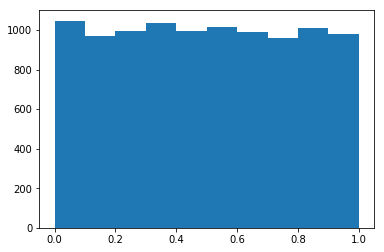

In [27]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
plt.hist(pvalues)
plt.show()

Корректность критерия

In [28]:
bad_pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    bad_pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05)
    
print(np.mean(bad_pvalues))

0.0527


Мощность критерия

0.1747


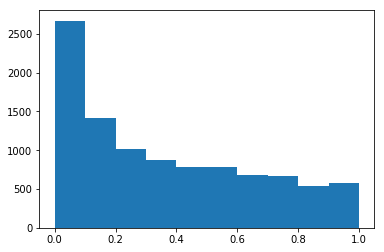

In [29]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

Усилим различие

0.5197


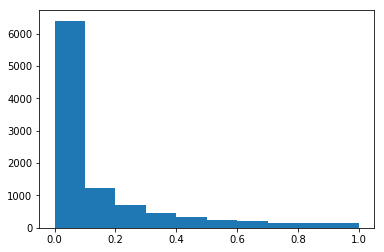

In [30]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(12, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

Увеличим выборку

0.8788


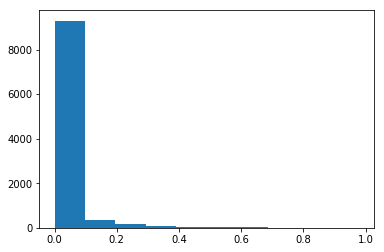

In [31]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=1000)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

# Перестановочные тесты

In [32]:
def my_test(data_fst, data_snd, iters=1000, plot=True):
    data = np.array(list(data_fst) + list(data_snd))
    size = len(data)
    values = []
    fst_ratio = len(data_fst) * 1. / size
    for _ in range(iters):
        mask = (np.random.random(size=size) < fst_ratio)
        values.append(data[mask].mean() - data[~mask].mean())
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return (np.abs(values) > np.abs(data_fst.mean() - data_snd.mean())).mean()

### Корректно ли такое применение?

0.07322397812817821


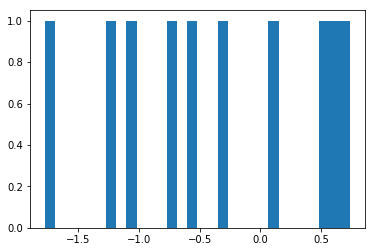

0.1


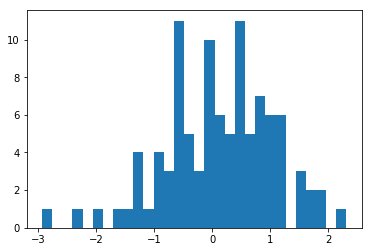

0.07


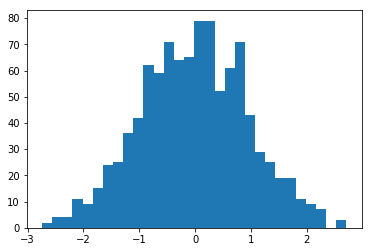

0.083


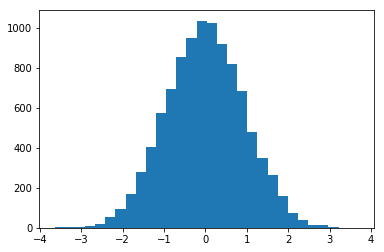

0.0745


In [33]:
data_fst = np.random.normal(0, 10, size=100)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_test(data_fst, data_snd, iters=10))
print(my_test(data_fst, data_snd, iters=100))
print(my_test(data_fst, data_snd, iters=1000))
print(my_test(data_fst, data_snd, iters=10000))

0.35405156961375017


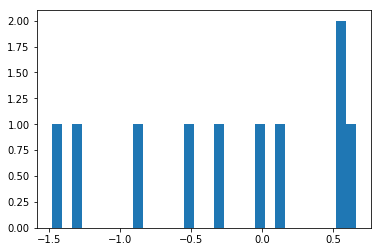

0.2


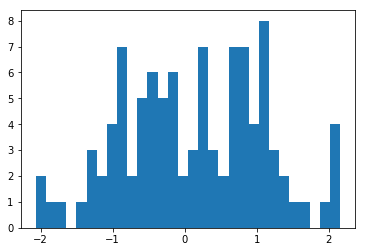

0.37


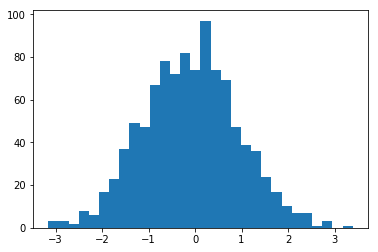

0.362


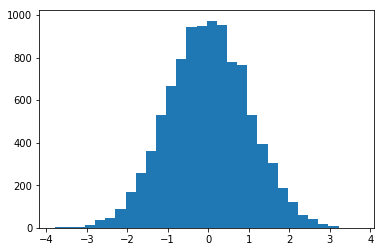

0.3525


In [34]:
data_fst = np.random.normal(0, 10, size=100)
data_snd = np.random.normal(1, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_test(data_fst, data_snd, iters=10))
print(my_test(data_fst, data_snd, iters=100))
print(my_test(data_fst, data_snd, iters=1000))
print(my_test(data_fst, data_snd, iters=10000))

К сожалению нет :(

Давайте в этом убедимся :(

In [35]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.002


In [36]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.0


Как с Мана-Уитни, нулевая гипотеза это что распределения совпадают

In [37]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

1.0


In [38]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.055


Вот это уже неплохо

# Bootstap

In [39]:
def my_bootstrap(data_fst, data_snd, iters=1000, plot=True):
    values = []
    for _ in range(iters):
        values.append(
            np.random.choice(data_fst, replace=True, size=len(data_fst)).mean()
            -
            np.random.choice(data_snd, replace=True, size=len(data_snd)).mean()
        )
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return np.percentile(values, [2.5, 97.5])

0.9614300424419936


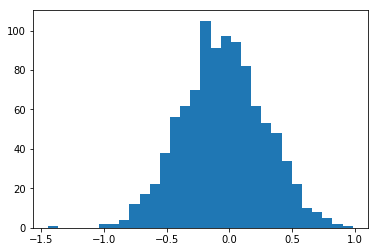

[-0.68628312  0.59937329]


In [40]:
data_fst = np.random.normal(0, 10, size=1000)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

0.42508421489990544


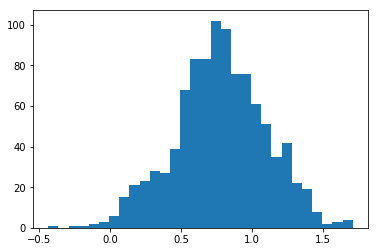

[0.10908305 1.38182164]


In [41]:
data_fst = np.random.normal(1, 10, size=1000)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

In [42]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.853


In [43]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.047


# Задание

1. Проверьте как будет работать ЦПТ для для бернулевских (scipy.stats.bernoulli) на маленьких выборках (до 10 элементов). Можно ли в этом случае более точно нулевое распределение подсчитать?
2. Протестируйте bootstrap (мощность и корректность), но добавьте в первую выборку два выброса - [-1000000, -1000000]. Сравните с поведением перестановочного теста в той же ситуации. Почему так получается?